# Activation Maximization

## How it works
Activation Maximization (AM) is a method of visually inspecting the preferred stimuli in neural network layers, similar to studying the neural firings in human brain. In short, this method is to find the image that maximizes the activation of a neuron, so that we can visually inspect what features or elements of an image were the stimuli. 

Let $\theta$ be the parameters of a classifier that maps an image $x \in \mathbb{R}^{H \times W \times C}$, where $C$ is the number of color channels, and the image is $W$ pixels wide and $H$ pixels high, onto a probability distribution over the output classes. The image $x$ can be found by the optimization problem 

$$ x^* = arg max_x (a_i^l(\theta, x))$$

where $a_i$ is the activation function of neuron $i$ in a given layer $l$.

The AM optimization problem can be solved using gradient ascent, that is, starting from a random initialization $x_0$, we iteratively take steps to find $x$ that highly activates a neuron using step size $\epsilon_1$ and gradient of $a(\theta, x)$: 

$$x_{t+1} = x_t + \epsilon_1 \frac{\partial a(\theta, x)}{\partial x_t}$$

## Applying AM on CNN using tf-keras-vis

We would use the package tf-keras-vis for the implementation of AM. More details can be found on https://keisen.github.io/tf-keras-vis-docs/index.html 


In [ ]:
# Uncomment and run the line below if you have not installed the package tf-keras-vis
# ! pip install tf-keras-vis 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


2024-01-10 15:56:15.878060: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-10 15:56:15.878121: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-10 15:56:15.878131: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-10 15:56:15.878247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-10 15:56:15.878355: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Prepare a simple CNN and train on the MNIST dataset

In this tutorial, we would train a simple CNN model using Keras on the MNIST dataset. It would be a digits classifier on 28 $\times$ 28 pixels grey images. Our goal is to apply AM to discover how the CNN model classify different digits.

In [2]:
# Import libraries
import keras
from keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.datasets import mnist

In [3]:
# Load data
(train_X, train_Y), (test_X, test_Y) = mnist.load_data()
# To verify that you have loaded the dataset correctly, 
# try printing out the shape of your train and test dataset matrices.
print('Train: X=%s, y=%s' % (train_X.shape, train_Y.shape))
print('Test: X=%s, y=%s' % (test_X.shape, test_Y.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


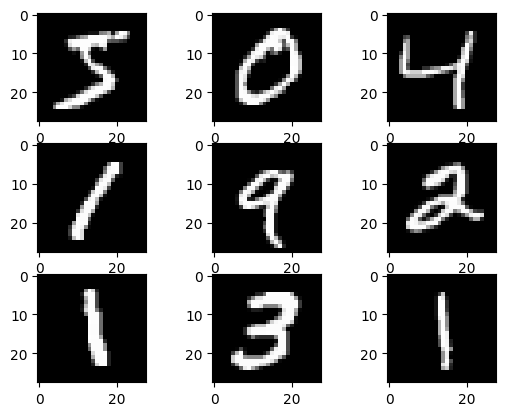

In [4]:
# Also, try to visualize individual images in this dataset by using imshow() function in pyplot.
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [5]:
# For preprocessing, scale the pixel values such that they lie between 0.0 and 1.0. 
# Make sure that you use the appropriate conversion to float wherever required while scaling.
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [6]:
def preprocess_data(train_X, train_Y, test_X, test_Y):
    # The data has images with 28 x 28 pixel values.
    # Since we use just one grayscale color channel, you need to reshape the matrix such that 
    # we have a 28 x 28 x 1 sized matrix holding each input data-point in the training and testing dataset.
    train_X = train_X.reshape((train_X.shape[0], 28, 28, 1))
    test_X = test_X.reshape((test_X.shape[0], 28, 28, 1))
    print('Train: X=%s, y=%s' % (train_X.shape, train_Y.shape))
    print('Test: X=%s, y=%s' % (test_X.shape, test_Y.shape))

    # The output variable can be converted into a one-hot vector by using the function to_categorical 
    # (make sure you import to_categorical from keras.utils). 
    train_Y = to_categorical(train_Y)
    test_Y = to_categorical(test_Y)

    train_X, test_X = prep_pixels(train_X, test_X)
    return train_X, train_Y, test_X, test_Y

Train: X=(60000, 28, 28, 1), y=(60000,)
Test: X=(10000, 28, 28, 1), y=(10000,)


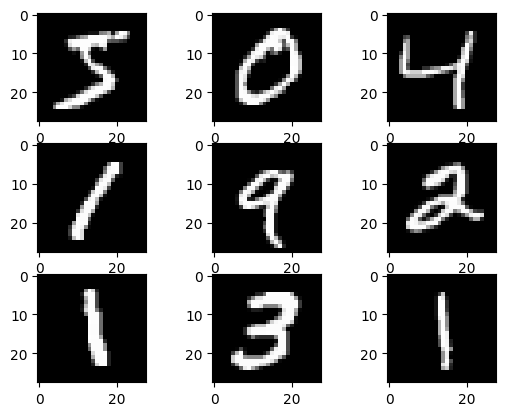

In [7]:
# Preprocess data
train_X, train_Y, test_X, test_Y = preprocess_data(train_X, train_Y, test_X, test_Y)

# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [8]:
# Create a CNN model
def create_cnn():
    # define using Sequential
    model = Sequential()
    # Convolution layer
    model.add(
        Conv2D(32, (3, 3), 
               activation='relu', 
               kernel_initializer='he_uniform', 
               input_shape=(28, 28, 1))
    )
    # Maxpooling layer
    model.add(MaxPooling2D((2, 2)))
    # Add another convolution later, use 64 output filters
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    # Flatten output
    model.add(Flatten())
    # Add dropout layer
    model.add(Dropout(0.5))
    # Dense layer of 100 neurons
    model.add(
        Dense(100, 
              activation='relu', 
              kernel_initializer='he_uniform')
    )
    model.add(Dense(10, activation='softmax'))
    # initialize optimizer
    opt = SGD(learning_rate=0.001, momentum=0.9)
    # compile model
    model.compile(
        optimizer=opt, 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

model = create_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [9]:
# Fit model on training data
history = model.fit(
    train_X,
    train_Y,
    batch_size=32,
    epochs=10,
    validation_split=0.1
)

Epoch 1/10
   1/1688 [..............................] - ETA: 8:52 - loss: 4.0262 - accuracy: 0.0625

2024-01-10 15:56:38.932080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-01-10 15:56:38.951977: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


1688/1688 [==============================] - 18s 10ms/step - loss: 0.4120 - accuracy: 0.8698 - val_loss: 0.1247 - val_accuracy: 0.9648
Epoch 2/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.1626 - accuracy: 0.9505 - val_loss: 0.0886 - val_accuracy: 0.9768
Epoch 3/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.1262 - accuracy: 0.9624 - val_loss: 0.0684 - val_accuracy: 0.9813
Epoch 4/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.1105 - accuracy: 0.9659 - val_loss: 0.0674 - val_accuracy: 0.9797
Epoch 5/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0988 - accuracy: 0.9697 - val_loss: 0.0569 - val_accuracy: 0.9833
Epoch 6/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0918 - accuracy: 0.9724 - val_loss: 0.0545 - val_accuracy: 0.9825
Epoch 7/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0894 - accuracy: 0.9729 - val_loss: 0.0546 - val_accura

In [10]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_X, test_Y, verbose=0)
print("test loss, test acc:", results)

Evaluate on test data
test loss, test acc: [0.06938362866640091, 0.9783000349998474]


Now, we got a model with fairly high accuracy. We can then move on to visualize the conv filters and dense layers for explaining how the CNN model gives predictions.

### Visualizing Conv Filters

In [11]:
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear

layer_name = 'conv2d_1' # The target layer that is the last layer.

# This instance constructs new model whose output is replaced to `layer_name` layer's output.
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
# This instance modify the model's last activation function to linear one.
replace2linear = ReplaceToLinear()

# Instead of using ExtractIntermediateLayer and ReplaceToLinear instance,
# you can also define the function from scratch as follows:
def model_modifier_function(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    target_layer.activation = tf.keras.activations.linear
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    return new_model

In [12]:
from tf_keras_vis.utils.scores import CategoricalScore

filter_number = 3
score = CategoricalScore(filter_number)

# Instead of using CategoricalScore object above,
# you can also define the function from scratch as follows:
def score_function(output):
    return output[..., filter_number]

In [13]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 # Please note that `extract_intermediate_layer` has to come before `replace2linear`.
                                                 model_modifier=[extract_intermediate_layer, replace2linear],
                                                 clone=False)

200/200 [==============================] - 2s 11ms/step - Score: -32.6682 - TotalVariation2D: 10.6173 - Norm: 3.3363


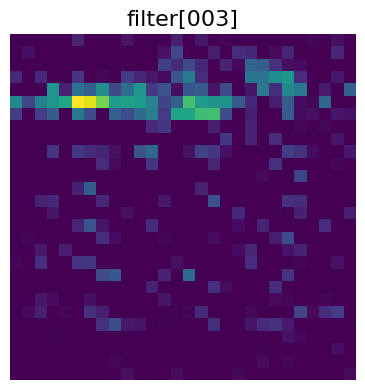

CPU times: user 1.83 s, sys: 424 ms, total: 2.25 s
Wall time: 2.32 s


In [14]:
%%time

from tf_keras_vis.activation_maximization.callbacks import Progress

# Generate maximized activation
activations = activation_maximization(score_function,
                                      callbacks=[Progress()])

## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(activations[0])
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

#### Visualizing multiple convolutional filters 

In [15]:
filter_numbers = list(range(10))
scores = CategoricalScore(filter_numbers)

In [16]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((10, 28, 28, 1), 0, 255)

In [17]:
%%time

from tf_keras_vis.activation_maximization.callbacks import Progress

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])

## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

200/200 [==============================] - 4s 21ms/step - Score: 70.2181 - TotalVariation2D: 17.4299 - Norm: 23.5529
CPU times: user 2.96 s, sys: 1.11 s, total: 4.07 s
Wall time: 4.36 s


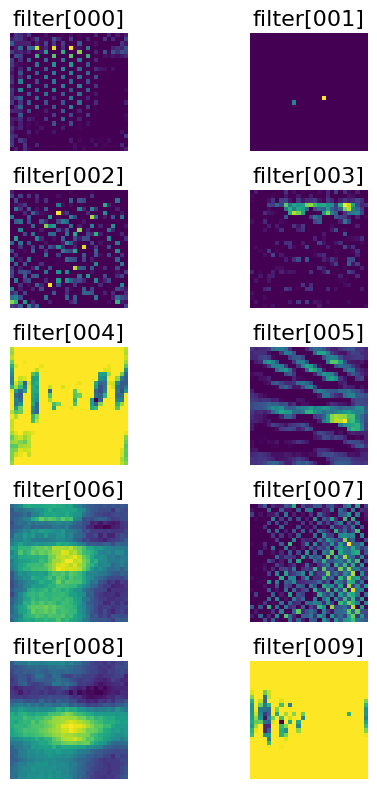

In [18]:
# Render
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(6, 8))
for i, filter_number in enumerate(filter_numbers):
    row = i // 2
    col = i % 2
    ax[row, col].set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
    ax[row, col].imshow(activations[i])
    ax[row, col].axis('off')
plt.tight_layout()
plt.show()

### Visualizing Dense Layers

In [19]:
replace2linear = ReplaceToLinear()

# Instead of using ReplaceToLinear instance,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [20]:
# 0 is the digit 0
score_num = 0
score = CategoricalScore(score_num)

# Instead of using CategoricalScore object above,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refer to the output of the model,
    # so, in this case, `output` shape is `(1, 1000)` i.e., (samples, classes).
    return output[:, score_num]

In [21]:
activation_maximization = ActivationMaximization(model,
                                                 model_modifier=replace2linear,
                                                 clone=True)

200/200 [==============================] - 2s 12ms/step - Score: 2569.8247 - TotalVariation2D: 34.7054 - Norm: 41.3599


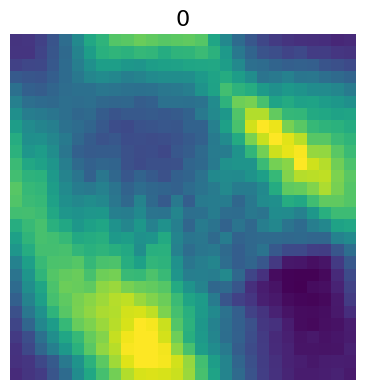

CPU times: user 1.98 s, sys: 426 ms, total: 2.41 s
Wall time: 2.45 s


In [22]:
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

# Generate maximized activation
activations = activation_maximization(score_function,
                                      callbacks=[Progress()])

## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(activations[0])
ax.set_title(f'{score_num}', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

#### Visualizing multiple dense layers

In [23]:
from tf_keras_vis.utils.scores import CategoricalScore

image_titles = [str(i) for i in range(10)]
scores = CategoricalScore(list(range(10)))

In [24]:
# Create `seed_input` whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((10, 28, 28, 1), 0, 255)

In [25]:
%%time

from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D
from tf_keras_vis.activation_maximization.callbacks import Progress, PrintLogger

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])

## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

200/200 [==============================] - 4s 22ms/step - Score: 414.5333 - TotalVariation2D: 27.1975 - Norm: 34.4441
CPU times: user 3.14 s, sys: 1.1 s, total: 4.23 s
Wall time: 4.46 s


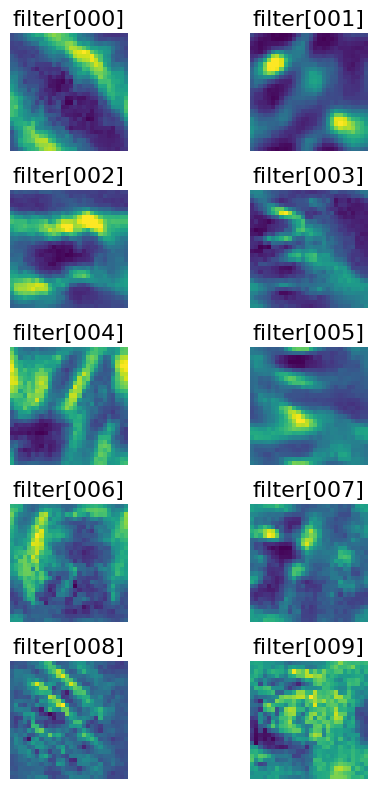

In [26]:
# Render
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(6, 8))
for i, filter_number in enumerate(filter_numbers):
    row = i // 2
    col = i % 2
    ax[row, col].set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
    ax[row, col].imshow(activations[i])
    ax[row, col].axis('off')
plt.tight_layout()
plt.show()

The images generated were not human-recognizable. Therefore, we want to constrain the search to be within a distribution of images that the model has seen. One simple approach is to use the mean of the training data as the image prior.

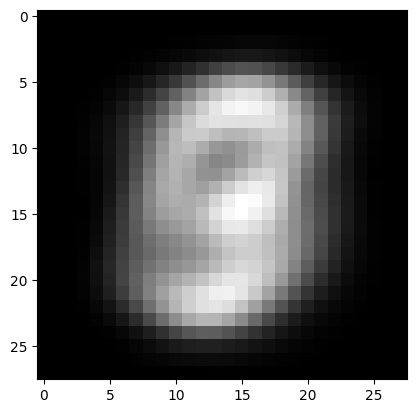

In [27]:
# image of the mean of training data
mean_X = train_X.mean(axis=0)
duplicated_array = np.tile(mean_X, (10, 1, 1, 1))
plt.imshow(mean_X, cmap=plt.get_cmap('gray'))

200/200 [==============================] - 4s 22ms/step - Score: 440.7175 - TotalVariation2D: 21.1135 - Norm: 6.2810


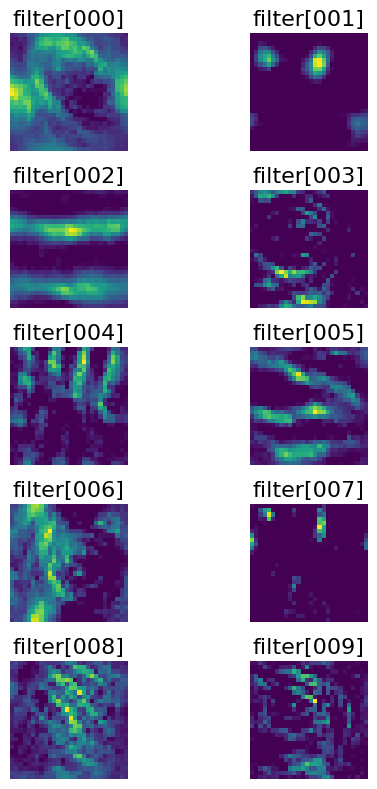

In [28]:
# Generate maximized activation again using the mean of training images
activations = activation_maximization(scores,
                                      seed_input=duplicated_array,
                                      callbacks=[Progress()])

# Render
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(6, 8))
for i, filter_number in enumerate(filter_numbers):
    row = i // 2
    col = i % 2
    ax[row, col].set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
    ax[row, col].imshow(activations[i])
    ax[row, col].axis('off')
plt.tight_layout()
plt.show()

You may discover that some of the images are able to display the distinctive features of the digits. For example, the shape of 6 and 9. However, some are less distinct. The images for 2 and 7 are less recognizable. 

## Using AM to debug CNN model

Now, let's take a look at the misclassification rate of each classes.

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the test set
y_pred = model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_Y, axis=1)

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Print the misclassification matrix by each class
for i in range(10):
    misclass_count = np.sum(confusion_mat[i]) - confusion_mat[i][i]
    print("Misclassification count for class", i, ":", misclass_count)

313/313 [==============================] - 1s 3ms/step
Misclassification count for class 0 : 15
Misclassification count for class 1 : 637
Misclassification count for class 2 : 106
Misclassification count for class 3 : 51
Misclassification count for class 4 : 41
Misclassification count for class 5 : 134
Misclassification count for class 6 : 32
Misclassification count for class 7 : 244
Misclassification count for class 8 : 1
Misclassification count for class 9 : 146


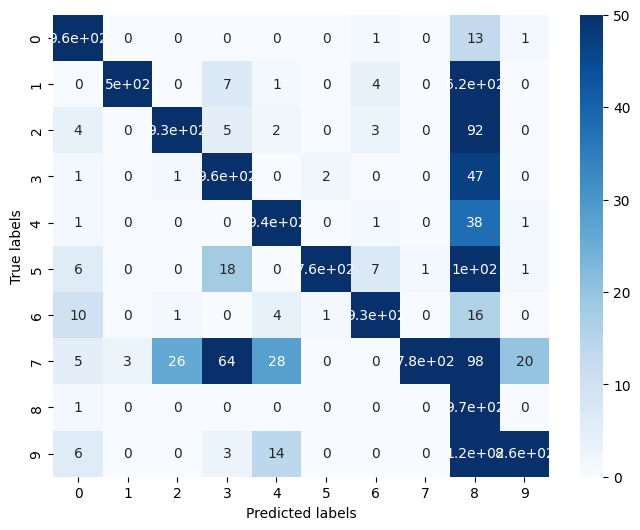

In [30]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap="Blues", vmin=0, vmax=50)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Digit 7 has the highest misclassfication rate, and from the confusion matrix we can see it is mostly confused with digit 2 and 3. Indeed, we can see from the AM images the features that activate the neurons at the dense layer may not be strong. This gives us some guidance on how we might improve the CNN model targeting specific digits' misclassifications. 